<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/POEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title download
# # https://drive.google.com/file/d/1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q/view?usp=sharing
# !gdown 1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q -O gsv.zip
# !unzip /content/gsv.zip -d /content
# import shutil
# shutil.rmtree('/content/google_street_view/meta_data', ignore_errors=True) # delete the meta_data folder

# # clip cleaned
# # https://drive.google.com/file/d/1-xcHyVAMeTkY7SUdUyQRVAn_FFXPSDGB/view?usp=share_link
!gdown 1-xcHyVAMeTkY7SUdUyQRVAn_FFXPSDGB -O gsv.zip
!unzip /content/gsv.zip -d /
!rm -R /content/gsv/.ipynb_checkpoints
!rm -R /content/gsv/01/.ipynb_checkpoints
!rm -R /content/gsv/02/.ipynb_checkpoints
!rm -R /content/gsv/03/.ipynb_checkpoints
!rm -R /content/gsv/04/.ipynb_checkpoints
!rm -R /content/gsv/05/.ipynb_checkpoints
!rm -R /content/gsv/06/.ipynb_checkpoints

# # gsv 70k
# # https://drive.google.com/file/d/1-7ZC29k4VxXQkpnOuLfj7Ag_SFTM4LV8/view?usp=share_link
# !gdown 1-7ZC29k4VxXQkpnOuLfj7Ag_SFTM4LV8 -O gsv.zip
# !unzip /content/gsv.zip -d /

# # # !ls
# !ls -a /content/gsv70k
# !rm -R /content/gsv70k/.ipynb_checkpoints
# # # !rm -R /content/gsv/06/.ipynb_checkpoints

# # https://bestasoff.medium.com/how-to-fine-tune-very-large-model-if-it-doesnt-fit-on-your-gpu-3561e50859af
!pip install bitsandbytes


In [1]:
# @title augmentations
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py

from PIL import ImageOps, ImageFilter
import numpy as np
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

class GaussianBlur(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            sigma = np.random.rand() * 1.9 + 0.1
            # return img.filter(ImageFilter.GaussianBlur(sigma))
            return transforms.GaussianBlur(kernel_size=5, sigma=sigma)(img)
        else:
            return img

class Solarization(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

class Cutout(object):
    def __init__(self, p=0.5, mask_size=140, mask_color=(0, 0, 0)):
        self.p = p
        self.mask_size = mask_size
        self.mask_color = mask_color
        self.mask_size_half = self.mask_size // 2
        # offset = 1 if mask_size % 2 == 0 else 0
    def __call__(self, img):
        if np.random.rand() > self.p:
            return img
        else:
            img = np.asarray(img).copy()
            h, w = img.shape[:2] # 480x600
            cx = np.random.randint(0, w)
            cy = np.random.randint(0, h)
            xmin, xmax = cx - self.mask_size_half, cx + self.mask_size_half
            ymin, ymax = cy - self.mask_size_half, cy + self.mask_size_half
            xmin, xmax = max(0, xmin), min(w, xmax)
            ymin, ymax = max(0, ymin), min(h, ymax)
            img[ymin:ymax, xmin:xmax] = self.mask_color
            return img


class TrainTransform(object):
    def __init__(self):
        self.transform = transforms.Compose([
                transforms.RandomPerspective(distortion_scale=0.3, p=0.5), # me
                # transforms.RandomResizedCrop(224, interpolation=InterpolationMode.BICUBIC),#224
                # transforms.RandomResizedCrop((400,640), interpolation=InterpolationMode.BICUBIC),#224
                # transforms.RandomResizedCrop((400,640), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomResizedCrop((400,640), scale=(0.7, 1.0), ratio=(0.8, 1.25), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5), # 0.5
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,), # brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8
                transforms.RandomGrayscale(p=0.2), # 0.2
                GaussianBlur(p=1.0), # 1.0
                # Solarization(p=0.0), # 0.0
                Cutout(p=1.0),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225
            ])

    def __call__(self, sample):
        x1 = self.transform(sample)
        # x2 = transforms.ToTensor()(sample)
        return x1
# https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py



# https://github.com/hysts/pytorch_cutout/blob/master/dataloader.py
# https://arxiv.org/pdf/1708.04552.pdf
# size of the cutout region is a more important hyperparameter than the shape
# randomly select a pixel coordinate within the image as a center point and then place the cutout mask around that location.
# alternative randomly apply cutout constrained within the image region, but with 50% probability so that the network sometimes receives unmodified images
def cutout(p=0.5, mask_size=16, mask_color=(0, 0, 0)):
    mask_size_half = mask_size // 2
    # offset = 1 if mask_size % 2 == 0 else 0
    def _cutout(image):
        image = np.asarray(image).copy()
        if np.random.random() > p:
            return image
        h, w = image.shape[:2]
        cx = np.random.randint(0, w)
        cy = np.random.randint(0, h)
        xmin, xmax = cx - mask_size_half, cx + mask_size_half
        ymin, ymax = cy - mask_size_half, cy + mask_size_half
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)
        image[ymin:ymax, xmin:xmax] = mask_color
        return image
    return _cutout



In [1]:
# @title data weighted
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# transform = transforms.Compose(transforms.ToTensor())

# dir='/content/google_street_view'
# dir='/content/gsv70k'
dir='/content/gsv'

# data = datasets.ImageFolder(dir, transform=transform)
data = datasets.ImageFolder(dir, transform=None)
torch.manual_seed(0)

# train_data, test_data = torch.utils.data.random_split(data, [.85,.15])
# https://www.scaler.com/topics/pytorch/how-to-split-a-torch-dataset/
data_size = len(data)
indices = np.arange(data_size)
np.random.shuffle(indices)
split_index = int(np.floor(0.9 * data_size))
train_idx, test_idx = indices[:split_index], indices[split_index:]
train_data = torch.utils.data.Subset(data, train_idx)
test_data = torch.utils.data.Subset(data, test_idx)
targets = np.array(data.targets)
train_targets = targets[train_idx]
test_targets = targets[test_idx]


from torch.utils.data import Dataset
class DatasetWrap(Dataset):
    def __init__(self, dataset, transform=None):
        super(DatasetWrap, self).__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

# train_data = DatasetWrap(train_data, TrainTransform()) # apply data augmentation to train dataset only
train_data = DatasetWrap(train_data, transform)
test_data = DatasetWrap(test_data, transform)

batch_size = 16 # 64

# https://stackoverflow.com/questions/62319228/number-of-instances-per-class-in-pytorch-dataset
from collections import Counter
class_count = torch.tensor(list(Counter(data.targets).values()))
weights=1./class_count
# weights=sum(class_count)/class_count
# print(weights)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler

train_weight = weights[train_targets]
test_weight = weights[test_targets]
train_sampler = torch.utils.data.WeightedRandomSampler(train_weight, len(train_weight))
test_sampler = torch.utils.data.WeightedRandomSampler(test_weight, len(test_weight))
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
data, train_data, test_data = None, None, None

num_batches=int(np.ceil(len(train_loader)/batch_size))

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# dataiter=None
# print(labels)

# dataiter = iter(test_loader)
# images, labels = next(dataiter)
# imshow(torchvision.utils.make_grid(images,nrow=4))
# dataiter=None


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# @title args
# Learning Probabilistic Ordinal Embeddings for Uncertainty-Aware Regression
# https://arxiv.org/pdf/2103.13629.pdf
# https://github.com/Li-Wanhua/POEs/tree/main/codes/adience_poe


# https://github.com/Li-Wanhua/POEs/blob/main/codes/adience_poe/poe/options.py

num-output-neurons', ' `reg` : 1; `cls`: `num_output_classes`; `rank`: `num_output_class` * 2.')
main-loss-type', default='reg', help='loss type in [cls, reg, rank].')
max-t', default=50, help='number of samples during sto.')

# args.cuda = not args.no_cuda and torch.cuda.is_available()
args.use_sto = True


In [10]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
# # https://pytorch.org/vision/0.12/models.html#id10
# model = models.resnet18(pretrained=True) # 18 34 50 101 152
# print(model)
# num_ftrs = model.fc.in_features
# model.fc = nn.Sequential( # og
#     nn.Linear(num_ftrs, 6, bias=False),
#     nn.Softmax(dim=1),
#     )
# model.fc = nn.Sequential(nn.Linear(num_ftrs, 6-1, bias=False),) # condor


# https://github.com/Li-Wanhua/POEs/blob/main/codes/adience_poe/poe/vgg.py
class POE(nn.Module):
    def __init__(self):
        super(POE, self).__init__()
        self.fwd = models.resnet18(pretrained=True)
        num_ftrs = self.fwd.fc.in_features # 512
        emb_dim=512 #4096
        self.fwd.fc = nn.Sequential(nn.Linear(num_ftrs, emb_dim), nn.ReLU(True), nn.Dropout(0.),)
        self.emd = nn.Sequential(nn.Linear(emb_dim, emb_dim), nn.ReLU(True),)
        self.var = nn.Sequential(nn.Linear(emb_dim, emb_dim), nn.BatchNorm1d(emb_dim, eps=0.001, affine=False),)
        self.drop = nn.Dropout(0.) # blank
        self.final = nn.Linear(emb_dim, 6)

    def forward(self, x, max_t=50, use_sto=False):
        x = self.fwd(x)
        emb = self.emd(x)
        log_var = self.var(x)
        sqrt_var = torch.exp(log_var * 0.5)
        if use_sto:
            rep_emb = emb[None].expand(max_t, *emb.shape)
            rep_sqrt_var = sqrt_var[None].expand(max_t, *sqrt_var.shape)
            norm_v = torch.randn_like(rep_emb).cuda()
            sto_emb = rep_emb + rep_sqrt_var * norm_v
            sto_emb = self.drop(sto_emb)
            logit = self.final(sto_emb)
        else:
            drop_emb = self.drop(emb)
            logit = self.final(drop_emb)
        return logit, emb, log_var

model=POE()

# # model.mods = [module for k, module in model._modules.items()]
# # modules = [module for k, module in model._modules.items()]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# model = torch.compile(model.to(device))
# model = torch.compile(model.to(device),mode='reduce-overhead')
model = torch.compile(model.to(device),mode='max-autotune')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# @title probordiloss
# https://github.com/Li-Wanhua/POEs/blob/main/codes/adience_poe/poe/probordiloss.py
import torch
import torch.nn as nn
import torch.nn.functional as F

def BhattacharyyaDistance(u1, sigma1, u2, sigma2):
    sigma_mean = (sigma1 + sigma2) / 2.0
    sigma_inv = 1.0 / (sigma_mean)
    dis1 = torch.sum(torch.pow(u1 - u2, 2) * sigma_inv, dim=1) / 8.0
    dis2 = 0.5 * (torch.sum(torch.log(sigma_mean), dim=1) - 0.5 * (torch.sum(torch.log(sigma1), dim=1) + torch.sum(torch.log(sigma2), dim=1)))
    return dis1 + dis2
def HellingerDistance(u1, sigma1, u2, sigma2): return torch.pow(1.0 - torch.exp(-BhattacharyyaDistance(u1, sigma1, u2, sigma2)), 0.5)

def WassersteinDistance(u1, sigma1, u2, sigma2):
    dis1 = torch.sum(torch.pow(u1 - u2, 2), dim=1)
    dis2 = torch.sum(torch.pow(torch.pow(sigma1, 0.5) - torch.pow(sigma2, 0.5), 2), dim=1)
    return torch.pow(dis1 + dis2, 0.5)

def GeodesicDistance(u1, sigma1, u2, sigma2):
    u_dis = torch.pow(u1 - u2, 2)
    std1 = sigma1.sqrt()
    std2 = sigma2.sqrt()
    sig_dis = torch.pow(std1 - std2, 2)
    sig_sum = torch.pow(std1 + std2, 2)
    delta = torch.div(u_dis + 2 * sig_dis, u_dis + 2 * sig_sum).sqrt()
    return torch.sum(torch.pow(torch.log((1.0 + delta) / (1.0 - delta)), 2) * 2, dim=1).sqrt()

def ForwardKLDistance(u1, sigma1, u2, sigma2):
    return -0.5 * torch.sum(torch.log(sigma1) - torch.log(sigma2) - torch.div(sigma1, sigma2) - torch.div(torch.pow(u1 - u2, 2), sigma2) + 1, dim=1)
def ReverseKLDistance(u2, sigma2, u1, sigma1):
    return -0.5 * torch.sum(torch.log(sigma1) - torch.log(sigma2) - torch.div(sigma1, sigma2) - torch.div(torch.pow(u1 - u2, 2), sigma2) + 1, dim=1)
def JDistance(u1, sigma1, u2, sigma2):
    return ForwardKLDistance(u1, sigma1, u2, sigma2) + ForwardKLDistance(u2, sigma2, u1, sigma1)

# 2,100,100
# *1 ,0.001, 0.01
class ProbOrdiLoss(nn.Module):
    # def __init__(self, distance='Bhattacharyya', alpha_coeff=0, beta_coeff=0, margin=0, main_loss_type='cls'):
    def __init__(self):
        super(ProbOrdiLoss, self).__init__()
        self.alpha_coeff = 1e-5 # paper:1e-4, args:1e-5
        self.beta_coeff = 1e-3 # paper:1e-5, args:1e-4
        self.margin = 10  # KL:5 ,wasserstein:100
        self.zeros = torch.zeros(1).cuda()

        # self.distrance_f = BhattacharyyaDistance
        self.distrance_f = WassersteinDistance
        # self.distrance_f = JDistance
        # self.distrance_f = ForwardKLDistance
        # self.distrance_f = HellingerDistance
        # self.distrance_f = GeodesicDistance
        # self.distrance_f = ReverseKLDistance


    def forward(self, logit, emb, log_var, target, use_sto=True):
        class_dim = logit.shape[-1]
        sample_size = logit.shape[0]  # reparameterized with max_t samples
        # main_loss_type in ['cls', 'reg', 'rank']
        # print(target.shape, sample_size) # [16] 50
        # print("in prob fwd: ",logit.view(-1, class_dim).shape, target.repeat(sample_size).shape) # [800, 6], [800]

        if use_sto: CEloss = F.cross_entropy(logit.view(-1, class_dim), target.repeat(sample_size)) # cls
        else: CEloss = F.cross_entropy(logit.view(-1, class_dim), target)
        # multi_hot_target = torch.zeros(self.num_output_bins).long() # from dataloader
        # multi_hot_target[list(range(target))] = 1
        # CEloss = F.mse_loss(logit.view(-1), target.repeat(sample_size).to(dtype=logit.dtype)) # reg
        # assert len(mh_target.shape) == 2, "target shape {} wrong".format(mh_target.shape) # rank
        # assert class_dim % 2 == 0, "class dim {} wrong".format(class_dim)
        # CEloss = F.cross_entropy(logit.view(-1, 2), mh_target.repeat([sample_size, 1]).view(-1))

        KLLoss = torch.mean(torch.sum(torch.pow(emb, 2) + torch.exp(log_var) - log_var - 1.0, dim=1) * 0.5)
        var = torch.exp(log_var)
        batch_size = emb.shape[0]
        dims = emb.shape[1]
        target_dis = torch.abs(target.view(-1, 1).repeat(1, batch_size) - target.view(1, -1).repeat(batch_size, 1))
        anchor_pos = [i for i in range(batch_size)]
        second_pos = [(i + 1) % batch_size for i in anchor_pos]
        target_dis = torch.abs(target_dis - torch.abs(target[anchor_pos] - target[second_pos]).view(-1, 1).repeat(1, batch_size))
        offset_m = torch.eye(batch_size).cuda().to(dtype=target_dis.dtype)
        target_dis = target_dis + offset_m * 1000
        target_dis[target_dis == 0] = 700
        thrid_pos = torch.argmin(target_dis, dim=1)

        anchor_sign = torch.sign(torch.abs(target[anchor_pos] - target[second_pos]) - torch.abs(target[anchor_pos] - target[thrid_pos]))
        emb_dis_12 = self.distrance_f(emb[anchor_pos, :], var[anchor_pos, :], emb[second_pos, :], var[second_pos, :])
        emb_dis_13 = self.distrance_f(emb[anchor_pos, :], var[anchor_pos, :], emb[thrid_pos, :], var[thrid_pos, :])

        anchor_cons = (emb_dis_13 - emb_dis_12) * anchor_sign.float() + self.margin
        loss_anchor = torch.max(self.zeros, anchor_cons) * torch.abs(anchor_sign).float()
        loss_mask = (anchor_cons > 0).to(dtype=anchor_sign.dtype)
        if sum(torch.abs(anchor_sign) * loss_mask) > 0:
            triple_loss = torch.sum(loss_anchor) / sum(torch.abs(anchor_sign) * loss_mask)
        else:
            triple_loss = torch.tensor(0.).cuda()
        # return CEloss, KLLoss * self.alpha_coeff, triple_loss * self.beta_coeff, CEloss + self.alpha_coeff * KLLoss + self.beta_coeff * triple_loss
        # print("CEloss, KLLoss, triple_loss: ", CEloss.item(), KLLoss.item(), triple_loss.item())
        return CEloss + self.alpha_coeff * KLLoss + self.beta_coeff * triple_loss


In [4]:
# @title metrics
# https://github.com/Li-Wanhua/POEs/blob/main/codes/adience_poe/poe/metrics.py
import torch
import torch.nn.functional as F

def cal_mae_acc_cls(logits, targets, is_sto=True):
    if is_sto:
        r_dim, s_dim, out_dim = logits.shape
        probs = F.softmax(logits, -1)
        label_arr = torch.arange(0, out_dim).to(device)
        exp = torch.sum(probs * label_arr, dim=-1)
        exp = torch.mean(exp, dim=0)
        mae = sum(abs(exp - targets)) * 1.0 / len(targets)
        acc = sum(exp.round() == targets) * 1.0 / len(targets)
    else:
        s_dim, out_dim = logits.shape
        probs = F.softmax(logits, -1)
        label_arr = torch.arange(out_dim).to(device)
        exp_data = torch.sum(probs * label_arr, axis=1)
        mae = sum(abs(exp_data - targets)) * 1.0 / len(targets)
        acc = sum(exp_data.round() == targets) * 1.0 / len(targets)
    return mae, acc



In [ ]:
# @title try

# # check model's input and output dimensions are correct
inputs = torch.rand(16, 3, 400, 640, device=device)
model.eval()
# logits = model(X)

# logit, emb, log_var = model(inputs, use_sto=True)
logit, emb, log_var = model(inputs, use_sto=False)

targets = torch.randint(0,6,(16,), device=device)
print(targets)

criterion = ProbOrdiLoss()
# criterion.to(device)
# loss = criterion(logit, emb, log_var, targets, use_sto=True)
loss = criterion(logit, emb, log_var, targets, use_sto=False)

# print(logit, emb, log_var)
print(logit.shape, emb.shape, log_var.shape, targets.shape) # [50, 16, 6], [16, 512], [16, 512], [16]
print(loss)

cal_mae_acc = cal_mae_acc_cls

# batch_mae, batch_acc = cal_mae_acc(logit, targets, True)
batch_mae, batch_acc = cal_mae_acc(logit, targets, False)
print(batch_mae, batch_acc)


out_dim = logit.shape[-1]
probs = F.softmax(logit, -1)
label_arr = torch.arange(out_dim).to(device)
exp_data = torch.sum(probs * label_arr, axis=1)
mae = sum(abs(exp_data - targets)) * 1.0 / len(targets)
pred = exp_data.round()
print(pred)


In [6]:
# @title train test function
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()
# https://github.com/prigoyal/pytorch_memonger/blob/master/models/optimized/resnet_new.py
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

# https://github.com/Li-Wanhua/POEs/blob/main/codes/adience_poe/test.py
# torch.manual_seed(0)
# np.random.seed(0)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# train function with automatic mixed precision
def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        # sy=sy.unsqueeze(-1)
        with torch.cuda.amp.autocast(): # automatic mixed percision
            # pred = model(sx) # default
            # modules = [module for k, module in model._modules.items()]
            # pred = checkpoint_sequential(functions=modules, segments=1, input=sx) # gradient checkpointing for resnet and inception only
            # # # pred = checkpoint_sequential(functions=model.mods, segments=1, input=sx)
            # loss = loss_fn(pred, sy) # /4 to scale by gradient accumulation_steps

            logit, emb, log_var = model(sx, use_sto=True)
            loss = loss_fn(logit, emb, log_var, sy, use_sto=True)
            # batch_mae, batch_acc = cal_mae_acc(logit, sy, True)

        scaler.scale(loss).backward()
        # if ((batch + 1) % 4 == 0) or (batch + 1 == len(dataloader)): # gradient accumulation
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        loss_list.append(loss.item())
        # loss.backward()
        # optimizer.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    return loss_list

def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        emd, mae, acc, acc1, num_examples = 0., 0., 0., 0., 0
        for X, y in dataloader:
            x, y = X.to(device), y.to(device)
            # pred = model(x)
            # # loss = loss_fn(pred, y)
            # # # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            # test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            # logit, emb, log_var = model(x)
            logit, emb, log_var = model(x, use_sto=False)
            loss = loss_fn(logit, emb, log_var, y, use_sto=False)
            test_loss += loss
            # batch_mae_no_sto, batch_acc_no_sto = cal_mae_acc(logit_no_sto, targets, False)
            out_dim = logit.shape[-1]
            probs = F.softmax(logit, -1)
            label_arr = torch.arange(out_dim).to(device)
            exp_data = torch.sum(probs * label_arr, axis=1)
            # mae = sum(abs(exp_data - targets)) * 1.0 / len(targets)
            pred = exp_data.round()

            correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    # if verbose: print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if verbose: print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss


In [11]:
pth='/content/lr.pth'
torch.save(model.state_dict(), pth) # save temporary model for lr finding


In [ ]:
# @title LR range test
# 1cycle super convergencehttps://arxiv.org/pdf/1708.07120.pdf
# # cyclic lr https://arxiv.org/pdf/1506.01186.pdf
# Note the learning rate value when the accuracy starts to
# increase and when the accuracy slows, becomes ragged, or starts to fall

# one training run of the network for a few epochs

epochs=5
min_lr= 1e-7
max_lr= 1e-3 # 1e-2
# 152: 1e-7 - 1e-4      result 3e-7 - 3e-6

# loss_fn = nn.CrossEntropyLoss()
loss_fn = ProbOrdiLoss()

model.load_state_dict(torch.load("lr.pth"))
# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=start_lr, momentum=0.9)
import bitsandbytes as bnb
optimizer = bnb.optim.AdamW(model.parameters(), lr=min_lr, betas=(0.9, 0.999), optim_bits=8)

# num_batches=int(np.ceil(len(test_loader)/batch_size))
num_batches=len(test_loader)

# total_steps=int(np.ceil(num_batches/4)*epochs)
total_steps=int(num_batches*epochs)

# min_lr* gamma^total_steps = max_lr
gamma = np.exp(np.log(max_lr/min_lr)/total_steps) # for scheduler step every optimizer step
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)
train_lst, test_lst=[],[]
lr_list=np.ones(total_steps)*min_lr*gamma**np.arange(total_steps)
# gamma = np.exp(np.log(max_lr/min_lr)/(total_steps*4)) # total_steps*4 bec grad accumulation, loss step 4x per lr step
# lr_list=np.ones(total_steps*4)*min_lr*gamma**np.arange(total_steps*4)


for i in range(epochs):
    train_ls = strain(test_loader, model, loss_fn, optimizer, scheduler)    
    train_lst.extend(train_ls)


# https://stackoverflow.com/a/53472966/13359815
from scipy.ndimage.filters import gaussian_filter1d
train_lstsm = gaussian_filter1d(train_lst, sigma=3)
end=200

import matplotlib.pyplot as plt
plt.plot(lr_list, train_lst)
plt.plot(lr_list, train_lstsm)
# plt.plot(lr_list[:end], train_lst[:end])
# plt.plot(lr_list[:end], train_lstsm[:end])
plt.xscale('log')
# plt.plot(train_lst)
# plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.close()


In [ ]:
print(len(lr_list))
start, end = 20, 220
plt.plot(lr_list[:end], train_lst[:end])
plt.plot(lr_list[:end], train_lstsm[:end])
plt.xscale('log')
# plt.plot(train_lst)
# plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst)
plt.show()
plt.close()

Epoch 1
-------------------------------
3.0000000000000018e-06


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[2023-05-31 08:07:18,323] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


loss: 1.948606 [    0/ 7421]
loss: 2.004870 [  736/ 7421]
loss: 1.952799 [ 1472/ 7421]
loss: 1.973953 [ 2208/ 7421]
loss: 1.791157 [ 2944/ 7421]
loss: 1.525497 [ 3680/ 7421]
loss: 1.446167 [ 4416/ 7421]
loss: 1.261767 [ 5152/ 7421]
loss: 1.073994 [ 5888/ 7421]
loss: 1.969004 [ 6624/ 7421]
loss: 1.638547 [ 7360/ 7421]


[2023-05-31 08:08:45,272] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[2023-05-31 08:08:55,727] torch._inductor.utils: [WARNING] skipping cudagraphs due to input mutation
[2023-05-31 08:09:06,073] torch._inductor.utils: [WARNING] skipping cudagraphs due to input mutation


Accuracy: 33.3%, Avg loss: 1.612175
Epoch 2
-------------------------------
1.416553484792832e-05


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss: 1.295438 [    0/ 7421]
loss: 1.608055 [  736/ 7421]
loss: 1.084623 [ 1472/ 7421]
loss: 0.988678 [ 2208/ 7421]
loss: 1.191229 [ 2944/ 7421]
loss: 1.811513 [ 3680/ 7421]
loss: 1.327257 [ 4416/ 7421]
loss: 1.741535 [ 5152/ 7421]
loss: 1.100009 [ 5888/ 7421]
loss: 1.606795 [ 6624/ 7421]
loss: 1.998906 [ 7360/ 7421]
Accuracy: 30.9%, Avg loss: 1.448552
Epoch 3
-------------------------------
2.919263295611303e-05
loss: 1.432752 [    0/ 7421]
loss: 1.597256 [  736/ 7421]
loss: 1.225147 [ 1472/ 7421]
loss: 1.964732 [ 2208/ 7421]
loss: 1.794785 [ 2944/ 7421]
loss: 1.211801 [ 3680/ 7421]
loss: 1.019990 [ 4416/ 7421]
loss: 1.107050 [ 5152/ 7421]
loss: 1.131680 [ 5888/ 7421]
loss: 1.298809 [ 6624/ 7421]
loss: 1.046073 [ 7360/ 7421]
Accuracy: 31.9%, Avg loss: 1.664397
Epoch 4
-------------------------------
2.3224170237120936e-05
loss: 1.165040 [    0/ 7421]
loss: 1.141723 [  736/ 7421]
loss: 0.969774 [ 1472/ 7421]
loss: 1.184927 [ 2208/ 7421]
loss: 0.952160 [ 2944/ 7421]
loss: 0.702249 [ 368

AttributeError: ignored

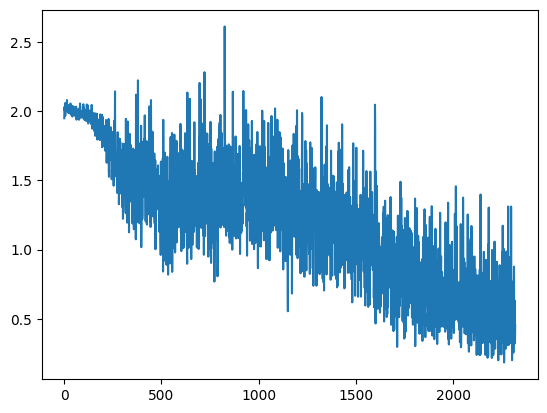

In [11]:
# @title wwwwwwwww
import time
start = time.time()
acc_lst, train_lst, test_lst=[],[],[]
# loss_fn = nn.CrossEntropyLoss()
loss_fn = ProbOrdiLoss()


base_lr, max_lr = 3e-6, 3e-5 # 1e-5, 1e-3 #0.5#
# res152 3e-7, 3e-6
# base_lr, max_lr = 3e-6, 3e-4
end_lr, start_lr = 1e-5, 1e-3 # 0.0001,0.1

epochs = 5 #5 20
# optimizer = torch.optim.SGD(model.parameters(), lr = start_lr, momentum=0.9)
# optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
import bitsandbytes as bnb # 8bit optimizer
optimizer = bnb.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), optim_bits=8)
# optimizer = bnb.optim.AdamW(model.parameters(), lr=1e-5, betas=(0.9, 0.999), optim_bits=8)
# 152 1e-5
# cnn 3e-4

div_factor = max_lr/base_lr
num_batches=len(train_loader)
total_steps=int(num_batches*epochs)+1
# total_steps=int(np.ceil(num_batches/4)*epochs)+1 # +1 to excluse uptick at the end of onecycle
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=100.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=div_factor, final_div_factor=10000.0, three_phase=True,)
# gamma = np.exp(np.log(end_lr/start_lr)/(num_batches*epochs)) # for scheduler step every optimizer step
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)


# for x in range(983):
#     scheduler.step()
#     # print(x)
# # 4916
# # 4915/5 = 983
# # 2321


for t in range(0,epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    print(lr)
    train_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)
    correct, test_loss = test(test_loader, model, loss_fn)
    train_lst.extend(train_ls)
    test_lst.append(test_loss)
    acc_lst.append(correct)

    # checkpoint = { # https://discuss.pytorch.org/t/saving-model-and-optimiser-and-scheduler/52030
    # 'epoch': t,
    # 'model': model.state_dict(),
    # 'optimizer': optimizer.state_dict(),
    # 'lr_sched': scheduler}
    # # torch.save(checkpoint, 'checkpoint.pth')
    # torch.save(checkpoint, '/content/drive/MyDrive/frame/resnet1522.pth')
    # torch.save(model.state_dict(), "model.pth")

print("Done!")

end = time.time()
print("time: ",end - start)

# print(len(train_lst), len(test_lst))
import matplotlib.pyplot as plt
plt.plot(train_lst)
plt.plot(np.linspace(0,len(train_lst),len(test_lst)), test_lst.cpu().numpy())
plt.show()
plt.plot(acc_lst)
plt.show()
plt.close()


torch.save(model.state_dict(), "model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))

# resnet 18, 60/61 38.4%, 528s
# resnet 18, 58/61 39.8%, 523s
# resnet 18 compile , 58/61 40.4%, 555s
# resnet 18 compile augment , 58/61 36.4%, 1941 # augment on cpu, takes longer
# resnet 18 augment lr3e-4:3e-3, 58/61 37.7%, 1863s
# resnet 18 augment 10epoch lr1e-5:3e-4, 58/61 33.5%, 3387s
# resnet 18 compile lr1e-5:3e-4, 58/61 35.0%, 493s
# resnet 18 compile scratch lr1e-5:1e-3, 58/61 26.8%, 475s
# resnet 18 compile lr1e-5:1e-3, 55/61 47.3%, 480s
# resnet 18 compile lr1e-5:1e-3, 52/61 51.7% 503s
# resnet 18 compile lr1e-5:1e-3, unfreeze 51.0%, 550s
# resnet 18 compile lr1e-5:1e-4, unfreeze 52.7%, 518s


# ordinal regression
# res18 condor 10k compile 3e-6;3e-5 5epochs 50.5%, 558s

# poe 3e-6, 3e-5 43.4% 451s
# 3e-5, 1e-4
# 1e-5,3e-5 30.3%, 457s
# 3e-6, 3e-5 40.8% 502s
# 1e-5, 1e-4 22.2%, 491s
# 3e-6, 3e-5 a1e-5, b1e-4 41.0%, 496s
# 3e-6, 3e-5 a1e-5, b1e-4 wasserstein 41.6%, 485s
# 3e-6, 3e-5 a-4b-5 wasserstein margin100 47.3%, 504

# 3e-6, 3e-5 a0.25b0.25 1epoch 16.4%, 402s
# 3e-6, 3e-5 augment a-a5b-3 wasserstein margin100 5epoch 42.8%, 1793s
# 1e-5, 3e-5 a-a5b-3 wasserstein margin100 5epoch lr too large
# 3e-6, 3e-5 a-a5b-3 wasserstein margin1 5epoch bad
# 3e-6, 3e-5 a-a5b-3 wasserstein margin5 5epoch 0.582425 45.5%, Avg loss: 1.553873 473s
# 3e-6, 3e-5 a-a5b-3 wasserstein margin10 5epoch 0.334923  42.2%, Avg loss: 1.785285 465s
# 3e-6, 3e-5 a-a5b-3 wasserstein margin25 5epoch bad?!
# 3e-6, 3e-5 a-a5b-3 wasserstein margin50 5epoch 0.579323 41.5%, Avg loss: 1.921989 469s
# 3e-6, 3e-5 a-a5b-3 wasserstein margin100 5epoch 41.7%, 464s





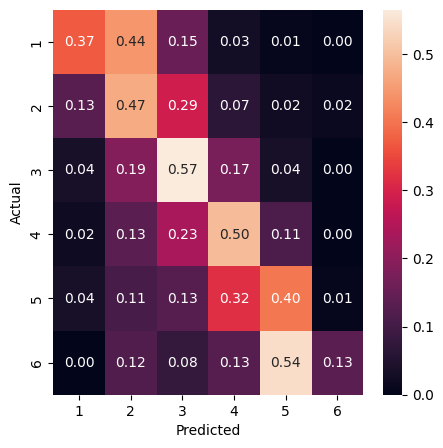

In [12]:
# @title confusion matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

model.eval()
test_loss, correct = 0, 0
y_true, y_pred = [], []
with torch.no_grad():
    emd, mae, acc, acc1, num_examples = 0., 0., 0., 0., 0
    for X, y in test_loader:
        x, y = X.to(device), y.to(device)
        # pred = model(x)
        # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # logit = model(x)

        logit, emb, log_var = model(x, use_sto=False)
        out_dim = logit.shape[-1]
        probs = F.softmax(logit, -1)
        label_arr = torch.arange(out_dim).to(device)
        exp_data = torch.sum(probs * label_arr, axis=1)
        predicted_labels = exp_data.round()

        y_true.extend(list(y.cpu()))
        y_pred.extend(list(predicted_labels.cpu()))

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['1','2','3','4','5','6',], yticklabels=['1','2','3','4','5','6',])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



In [ ]:
# @title save

# from google.colab import drive
# drive.mount('/content/drive')

# # pth='/content/drive/MyDrive/frame/vit.pth'
# pth='/content/drive/MyDrive/frame/res55.pth'
# pth='/content/drive/MyDrive/frame/resnet152.pth'

torch.save(model.state_dict(), pth)
# model.load_state_dict(torch.load(pth))
# # model.load_state_dict(torch.load("model.pth"))





# # https://drive.google.com/file/d/1visTNvWmnuV7jAm2TBiAIIrNjbOAi1Fv/view?usp=share_link
# !gdown 1visTNvWmnuV7jAm2TBiAIIrNjbOAi1Fv -O resnet152.pth

# # t, modelsd, optimsd, scheduler = torch.load('/content/drive/MyDrive/frame/resnet152.pth').values()
# t, modelsd, optimsd, scheduler = torch.load('/content/resnet152.pth').values()
# model.load_state_dict(modelsd)
# # optimizer.load_state_dict(optimsd)



# # matt152 # https://drive.google.com/file/d/1MQ0xLfHbio458uEVbn2VyMpD3bij2A4J/view?usp=sharing
# !gdown 1MQ0xLfHbio458uEVbn2VyMpD3bij2A4J -O res152.pth
# model.load_state_dict(torch.load("res152.pth"))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
